# Overview

LangGraph is built for developers who want to build powerful, adaptable AI agents. Developers choose LangGraph for:

* **Reliability and controllability.** Steer agent actions with moderation checks and human-in-the-loop approvals. LangGraph persists context for long-running workflows, keeping your agents on course.
* **Low-level and extensible.** Build custom agents with fully descriptive, low-level primitives free from rigid abstractions that limit customization. Design scalable multi-agent systems, with each agent serving a specific role tailored to your use case.
* **First-class streaming support.** With token-by-token streaming and streaming of intermediate steps, LangGraph gives users clear visibility into agent reasoning and actions as they unfold in real time.

# Learn LangGraph basics

To get acquainted with LangGraph's key concepts and features, complete the following LangGraph basics tutorials series:

* Build a basic chatbot
* Add tools
* Add memory
* Add human-in-the-loop controls
* Customize state
* Time travel

In completing this series of tutorials, you will build a support chatbot in LangGraph that can:

✅ Answer common questions by searching the web
✅ Maintain conversation state across calls
✅ Route complex queries to a human for review
✅ Use custom state to control its behavior
✅ Rewind and explore alternative conversation paths

# Build a basic chatbot

In this tutorial, you will build a basic chatbot. This chatbot is the basis for the following series of tutorials where you will progressively add more sophisticated capabilities, and be introduced to key LangGraph concepts along the way. Let’s dive in! 🌟

## Prerequisites

Before you start this tutorial, ensure you have access to a LLM that supports tool-calling features, such as OpenAI, Anthropic, or Google Gemini.

## 1. Install packages

Install the required packages:

In [ ]:
!pip install -U langgraph langsmith langchain langchain_google_genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requ

**Tip**: Sign up for [LangSmith](https://smith.langchain.com/) to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph. For more information on how to get started, see [LangSmith docs](https://docs.smith.langchain.com/).

## 2. Create a StateGraph

Now you can create a basic chatbot using LangGraph. This chatbot will respond directly to user messages.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

**API Reference:** [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#stategraph) | [START](https://langchain-ai.github.io/langgraph/reference/graphs/#start) | [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#add_messages)

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Our graph can now handle two key tasks:

* Each `node` can receive the current `State` as input and output an update to the state.
* Updates to `messages` will be appended to the existing list rather than overwriting it, thanks to the prebuilt `add_messages` function used with the `Annotated` syntax.

**Concept**: When defining a graph, the first step is to define its `State`. The `State` includes the graph's schema and reducer functions that handle state updates. In our example, `State` is a `TypedDict` with one key: `messages`. The `add_messages` reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values. To learn more about state, reducers, and related concepts, see [LangGraph reference docs](https://langchain-ai.github.io/langgraph/concepts/).

## 3. Add a node

Next, add a "chatbot" node. `Nodes` represent units of work and are typically regular Python functions.

Let's first select and set up a chat model (we'll use Google Gemini here). You will need to get a [Google API Key](https://ai.google.dev/pricing) and set it as an environment variable.

In [ ]:
import os
import getpass
from langchain_google_genai import ChatGoogleGenerativeAI

# Get your API key (replace with your actual key or use a secure method)
# os.environ["GOOGLE_API_KEY"] = "..."

# Or use getpass for a more secure input method in Colab
if "GOOGLE_API_KEY" not in os.environ:
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Provide your Google API Key")

# Initialize the Chat Model
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20")

We can now incorporate the chat model into a simple node:

In [ ]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Notice how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the LLM's response messages to whatever messages are already in the state.

## 4. Add an entry point

Add an `entry` point to tell the graph where to start its work each time it is run:

In [ ]:
graph_builder.add_edge(START, "chatbot")

## 5. Compile the graph

Before running the graph, we'll need to compile it. We can do so by calling `compile()` on the graph builder. This creates a `CompiledGraph` we can invoke on our state.

In [ ]:
graph = graph_builder.compile()

## 6. Visualize the graph (optional)

You can visualize the graph using the get_graph method and one of the "draw" methods, like draw_ascii or draw_png. The draw methods each require additional dependencies.



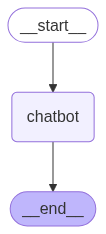

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 7. Run the chatbot

Now run the chatbot! We'll use the `stream` method to see the updates as they happen.

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: 


/usr/local/lib/python3.11/dist-packages/langchain_google_genai/chat_models.py:1501: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


User: What do you know about LangGraph?
Assistant: LangGraph is a library that extends the capabilities of LangChain by providing a way to build **robust and stateful multi-actor applications** using a **graph-based approach**.

Essentially, while LangChain provides the building blocks (LLMs, tools, chains, agents), LangGraph gives you a powerful framework to **orchestrate complex sequences of operations, manage state, and handle intricate control flow**, especially for applications that require multiple steps, conditional logic, and iterative processes.

Here's a breakdown of what LangGraph is and what it offers:

### Core Concepts

1.  **State:** At the heart of LangGraph is the concept of `State`. This is a shared object that gets passed between different nodes in your graph. Any node can read from or write to this state, allowing information to persist and evolve across multiple steps of your application. This is crucial for multi-turn conversations, agents that need to remember pr

## Congratulations! 🎉

You've built your first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM.

## Next steps

You may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

# Add tools 🛠️

To handle queries your chatbot can't answer "from memory", integrate a web search tool. The chatbot can use this tool to find relevant information and provide better responses.

**Note**: This tutorial builds on *Build a basic chatbot*.

## Prerequisites

Before you start this tutorial, ensure you have the following:

* An API key for the [Tavily Search Engine](https://tavily.com/).

## 1. Install the search engine

Install the requirements to use the Tavily Search Engine:

In [ ]:
!pip install -U langchain-tavily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 59.6 MB/s eta 0:00:00


## 2. Configure your environment

Configure your environment with your search engine API key. We use `getpass` here for secure input.

In [ ]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


## 3. Define the tool

Define the web search tool.

**API Reference:** [TavilySearch](https://python.langchain.com/v0.1/docs/integrations/tools/tavily_search/)

In [ ]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'content': 'Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges, allowing you to dynamically determine the next node to execute based on the current state of the graph. We define nodes for classifying the input, handling greetings, and handling search queries. def classify_input_node(state): LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its powe

## 4. Define the graph

For the `StateGraph` you created in the first tutorial, add `bind_tools` on the LLM. This lets the LLM know the correct JSON format to use if it wants to use the search engine.

Let's first select our LLM (Google Gemini) and set the API key if you haven't already.

In [ ]:
import os
import getpass
from typing import Annotated
from typing_extensions import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Set up LLM API Key if needed
if "GOOGLE_API_KEY" not in os.environ:
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Provide your Google API Key")

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20")

# Bind the tools to the LLM
llm_with_tools = llm.bind_tools(tools)

# Define the State
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Define the chatbot node (now with tool awareness)
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

## 5. Create a function to run the tools

Now, create a function to run the tools if they are called. We'll create a `BasicToolNode` class that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's tool_calling support.

**API Reference:** [ToolMessage](https://langchain-ai.github.io/langgraph/reference/messages/#toolmessage)

In [ ]:
import json
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode, tools_condition

# class BasicToolNode:
#     """A node that runs the tools requested in the last AIMessage."""

#     def __init__(self, tools: list) -> None:
#         self.tools_by_name = {tool.name: tool for tool in tools}

#     def __call__(self, inputs: dict):
#         if messages := inputs.get("messages", []):
#             message = messages[-1]
#         else:
#             raise ValueError("No message found in input")
#         outputs = []
#         for tool_call in message.tool_calls:
#             tool_result = self.tools_by_name[tool_call["name"]].invoke(
#                 tool_call["args"]
#             )
#             outputs.append(
#                 ToolMessage(
#                     content=json.dumps(tool_result),
#                     name=tool_call["name"],
#                     tool_call_id=tool_call["id"],
#                 )
#             )
#         return {"messages": outputs}

# tool_node = BasicToolNode(tools=[tool])

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

print("ToolNode added to the graph.")

ToolNode added to the graph.


**Note**: If you do not want to build this yourself in the future, you can use LangGraph's prebuilt `ToolNode`.

## 6. Define the conditional edges

With the tool node added, now you can define the `conditional_edges`.

*Edges* route the control flow from one node to the next. *Conditional edges* start from a single node and usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Next, define a router function called `route_tools` that checks for `tool_calls` in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and `END` if not.

In [ ]:
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition


# def route_tools(state: State) -> str:
#     """
#     Use in the conditional_edge to route to the ToolNode if the last message
#     has tool calls. Otherwise, route to the end.
#     """
#     messages = state["messages"]
#     last_message = messages[-1]

#     if hasattr(last_message, "tool_calls") and last_message.tool_calls:
#         return "tools"

#     return END

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.

# graph_builder.add_conditional_edges(
#     "chatbot",
#     route_tools,
#     {
#         "tools": "tools",
#         END: END
#     },
# )


graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

ValueError: Branch with name `tools_condition` already exists for node `chatbot`

**Note**: You can replace this with the prebuilt `tools_condition` to be more concise.

## 7. Visualize the graph (optional)

You can visualize the graph using the `get_graph` method.

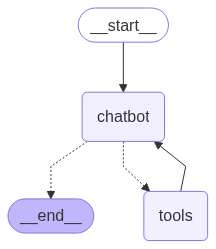

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 8. Ask the bot questions

Now you can ask the chatbot questions outside its training data:

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: 


/usr/local/lib/python3.11/dist-packages/langchain_google_genai/chat_models.py:1501: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


User: What do you know about LangGraph?
Assistant: 
Assistant: {"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "What is LangGraph? - IBM", "url": "https://www.ibm.com/think/topics/langgraph", "content": "LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGrap

## Congratulations! 🥳

You've created a conversational agent in LangGraph that can use a search engine to retrieve updated information when needed. Now it can handle a wider range of user queries.

## Next steps

The chatbot cannot remember past interactions on its own, which limits its ability to have coherent, multi-turn conversations. In the next part, you will add memory to address this.

# Add memory 🧠

The chatbot can now use tools to answer user questions, but it does not remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that checkpointing is *much* more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But first, let's add checkpointing to enable multi-turn conversations.

**Note**: This tutorial builds on *Add tools*.

## 1. Create a `MemorySaver` checkpointer

Create a `MemorySaver` checkpointer. This is an in-memory checkpointer, convenient for tutorials. In production, you'd likely use `SqliteSaver` or `PostgresSaver`.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## 2. Compile the graph

Compile the graph with the provided checkpointer, which will checkpoint the `State` as the graph works through each node:

In [ ]:
graph = graph_builder.compile(checkpointer=memory)

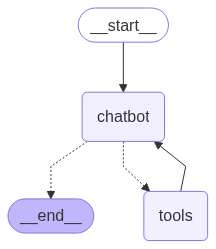

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 3. Interact with your chatbot

Now you can interact with your bot!

* Pick a thread to use as the key for this conversation.
* Call your chatbot.

**Note**: The `config` must be provided as the **second positional argument** when calling `stream()` or `invoke()`. It should *not* be nested within the graph inputs.

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!


events = graph.stream(
    {"messages": [HumanMessage(content=user_input)]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Nice to meet you, Will! How can I help you today?


## 4. Ask a follow up question

Ask a follow up question. Notice we use the *same* `config`.

In [ ]:
user_input = "What is my name?"

# The config is the **second positional argum«ent** to stream() or invoke()!
events = graph.stream(
    {"messages": [HumanMessage(content=user_input)]},
    config,
    stream_mode="values",
)

# print(f"User: {user_input}")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Will.


Notice that we aren't using an external list for memory: it's all handled by the checkpointer!

Don't believe me? Try this using a *different* config (a new `thread_id`).

In [ ]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I do not know your name. I am a large language model, trained by Google.


Notice that the only change we've made is to modify the `thread_id` in the config. The bot doesn't remember the name in this new thread.

## 5. Inspect the state

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [ ]:
snapshot = graph.get_state(config)

print("Snapshot for thread_id='1':")
print(f"Next node to execute: {snapshot.next}")
print("--- Messages ---")
for msg in snapshot.values['messages']:
  msg.pretty_print()


Snapshot for thread_id='1':
Next node to execute: ()
--- Messages ---
================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Nice to meet you, Will! How can I help you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Will.


The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `END` state, so `next` is empty.

## Congratulations! ✅

Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles arbitrarily complex graph states, which is much more expressive and powerful than simple chat memory.

## Next steps

In the next tutorial, you will add human-in-the-loop to the chatbot to handle situations where it may need guidance or verification before proceeding.

# Add human-in-the-loop controls 🧑‍💻

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph's **persistence** layer supports **human-in-the-loop** workflows, allowing execution to pause and resume based on user feedback. The primary interface to this functionality is the `interrupt` function. Calling `interrupt` inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a `Command`. `interrupt` is ergonomically similar to Python's built-in `input()`, with some caveats.

**Note**: This tutorial builds on *Add memory*.

## 1. Add the `human_assistance` tool

Starting with the existing code, add the `human_assistance` tool to the chatbot. This tool uses `interrupt` to receive information from a human.

First, set up the LLM and the necessary imports. Then, define the `human_assistance` tool and add it to our list.

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

**Tip**: For more information and examples of human-in-the-loop workflows, see [Human-in-the-loop docs](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/). This includes how to review and edit tool calls before they are executed.

## 2. Compile the graph

We compile the graph with a checkpointer, as before:

In [ ]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

## 3. Visualize the graph (optional)

Visualizing the graph, you get the same layout as before – just with the added tool!

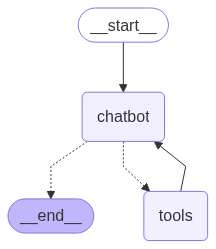

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 4. Prompt the chatbot

Now, prompt the chatbot with a question that will engage the new `human_assistance` tool. Execution will pause when the tool is called.

In [ ]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (e4b0660e-e655-4ae5-a1e2-bb3dc3ee493c)
 Call ID: e4b0660e-e655-4ae5-a1e2-bb3dc3ee493c
  Args:
    query: Expert guidance for building an AI agent.


The chatbot generated a tool call, but then execution has been interrupted. If you inspect the graph state, you see that it stopped at the tools node:

In [ ]:
snapshot = graph.get_state(config)
print(snapshot.next)

('tools',)


## 5. Resume execution

To resume execution, pass a `Command` object containing data expected by the tool. For our `human_assistance` tool, we expect a dictionary with a key `"data"`.

In [ ]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (e4b0660e-e655-4ae5-a1e2-bb3dc3ee493c)
 Call ID: e4b0660e-e655-4ae5-a1e2-bb3dc3ee493c
  Args:
    query: Expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.


The input has been received and processed as a tool message. The graph continued execution and provided a final answer.

## Congratulations! 🙌

You've used an `interrupt` to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential UIs you can create with your AI systems. Since you have already added a `checkpointer`, as long as the underlying persistence layer is running, the graph can be paused **indefinitely** and resumed at any time as if nothing had happened.

## Next steps

So far, the tutorial examples have relied on a simple state with one entry: a list of messages. You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state.

# Customize state ⚙️

In this tutorial, you will add additional fields to the state to define complex behavior without relying solely on the message list. The chatbot will use its search tool to find specific information and then forward it to a human for review, updating the custom state fields in the process.

**Note**: This tutorial builds on *Add human-in-the-loop controls*.

## 1. Add keys to the state

Update the chatbot to research the birthday of an entity by adding `name` and `birthday` keys to the state:

**API Reference:** [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#add_messages)

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

Adding this information to the state makes it easily accessible by other graph nodes and the graph's persistence layer.

## 2. Update the state inside the tool

Now, populate these state keys inside of the `human_assistance` tool. This allows a human to review the information before it is stored in the state. We will use `Command` to issue a state update from inside the tool.

We also need `InjectedToolCallId` to associate the `ToolMessage` we'll create with the original LLM tool call.

In [ ]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance_name_birthday(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

## 3. Prompt the chatbot

Prompt the chatbot to look up the "birthday" of the LangGraph library and direct it to use the `human_assistance` tool once it has an answer. This will trigger the search, followed by the interrupt.

In [ ]:
tool = TavilySearch(max_results=2)
tools = [tool, human_assistance_name_birthday]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, provide the name which should be LangGraph and the birthday and use the human_assistance_name_birthday tool for review."
    "If you cannot find the birthday and name, you just use random ones"
    "once you have the correction from humans, you give the users the correct answers without any explanations"
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, provide the name which should be LangGraph and the birthday and use the human_assistance_name_birthday tool for review.If you cannot find the birthday and name, you just use random onesonce you have the correction from humans, you give the users the correct answers without any explanations
================================== Ai Message ==================================
Tool Calls:
  tavily_search (875549b2-97ed-4d17-a5de-1374b2359c36)
 Call ID: 875549b2-97ed-4d17-a5de-1374b2359c36
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph release date", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Announcing LangGraph v0.1 & LangGraph Cloud: Running agents at scale ...", "url": "https://blog.lan

We've hit the `interrupt` in the `human_assistance` tool again. The chatbot *thinks* it found 'Jan 17, 2024' but asked for verification.

## 4. Add human assistance

The chatbot failed to identify the correct date (or rather, it *did*, but we're testing the flow), so supply it with information (or confirm it). Let's pretend it was wrong and correct it.

In [ ]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    }
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance_name_birthday (7ff3081c-75f3-4cb1-b522-beb351578e75)
 Call ID: 7ff3081c-75f3-4cb1-b522-beb351578e75
  Args:
    birthday: January 1, 2023
    name: LangGraph
================================= Tool Message =================================
Name: human_assistance_name_birthday

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph was released on Jan 17, 2024.


Note that these fields are now reflected in the state:

In [ ]:
snapshot = graph.get_state(config)

print({k: v for k, v in snapshot.values.items() if k in ("name", "birthday")})

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}


## 5. Manually update the state

LangGraph gives a high degree of control over the application state. For instance, at any point (including when interrupted), you can manually override a key using `graph.update_state`:

In [ ]:
print("Updating state manually...")
new_config = graph.update_state(config, {"name": "LangGraph (library)"})
print(f"State updated. New config: {new_config}")

Updating state manually...
State updated. New config: {'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03b278-eeb1-666f-8008-b5a8d06db5f4'}}


## 6. View the new value

If you call `graph.get_state` (using the *original* config, as `update_state` creates a *new* checkpoint), you can see the new value is reflected:

In [ ]:
snapshot = graph.get_state(config)

print({k: v for k, v in snapshot.values.items() if k in ("name", "birthday")})

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}


Manual state updates will generate a trace in LangSmith. If desired, they can also be used to control human-in-the-loop workflows. Use of the `interrupt` function is generally recommended instead, as it allows data to be transmitted in a human-in-the-loop interaction independently of state updates.

## Congratulations! ✨

You've added custom keys to the state to facilitate a more complex workflow and learned how to generate state updates from inside tools.

## Next steps

There's one more concept to review before finishing the LangGraph basics tutorials: connecting checkpointing and state updates to **time travel**.

# Time travel ⏳

In a typical chatbot workflow, the user interacts with the bot one or more times to accomplish a task. Memory and human-in-the-loop enable checkpoints in the graph state and control future responses.

What if you want a user to be able to start from a previous response and explore a different outcome? Or what if you want users to be able to rewind your chatbot's work to fix mistakes or try a different strategy, something that is common in applications like autonomous software engineers?

You can create these types of experiences using LangGraph's built-in **time travel** functionality.

**Note**: This tutorial builds on *Customize state*, but for simplicity, we will use the tool-using graph with memory for demonstration.

## 1. Setup the Graph

First, let's set up the graph we'll use for time travel. This will be a tool-using agent with memory.

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

## 2. Add steps

Add steps to your graph by interacting with it. Every step will be checkpointed in its state history:

In [ ]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (1941d1cc-5e09-4f53-8362-735ec81c077c)
 Call ID: 1941d1cc-5e09-4f53-8362-735ec81c077c
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "What is LangGraph? - IBM", "url": "https://www.ibm.com/think/topics/langgraph", "content": "LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illumin

In [ ]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================
Tool Calls:
  tavily_search (6969dc07-b5ed-4232-9079-836399a957e8)
 Call ID: 6969dc07-b5ed-4232-9079-836399a957e8
  Args:
    query: how to build an autonomous agent with LangGraph
================================= Tool Message =================================
Name: tavily_search

{"query": "how to build an autonomous agent with LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "How to Build the Ultimate AI Automation with Multi-Agent Collaboration", "url": "https://blog.langchain.dev/how-to-build-the-ultimate-ai-automation-with-multi-agent-collaboration/", "content": "Editor's Note: The following post is authored by Assaf Elovic, Head of R&D at Wix. In this blog, he walks through how to build an autonomous research as

## 3. Replay the full state history

Now that you have added steps to the chatbot, you can replay the full state history to see everything that occurred. We will identify a specific state to 'travel' back to.

In [ ]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 4:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

Checkpoints are saved for every step of the graph and span invocations, so you can rewind across a full thread's history.

## 4. Resume from a checkpoint (Time Travel!)

Resume from the `to_replay` state. The checkpoint's `to_replay.config` contains a `checkpoint_id`. Providing this value tells LangGraph's checkpointer to load the state from that moment in time. We'll start *before* the second tool call and can now proceed differently.

In [ ]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03b27c-3f3d-65f4-8003-a61f61509745'}}


In [ ]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

LangGraph, created by LangChain, is an open-source AI agent framework designed for building, deploying, and managing complex generative AI agent workflows.

At its core, LangGraph uses graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. In LangGraph, "nodes" represent individual components or agents within an AI workflow. It provides transparency into the agent's state and processes, allowing for enhanced decision-making by enabling AI agents to analyze past actions and feedback.

LangGraph is particularly useful for developing AI solutions and workflows that require long-running and stateful agents, such as chatbots and state graphs. While it can be used standalone, it also integrates seamlessly with other LangChain products.


The graph loaded the state from the past but proceeded with the *new* user input, effectively changing the conversation's direction. You've successfully traveled through time!

## Congratulations! 🚀

You've now used time-travel checkpoint traversal in LangGraph. Being able to rewind and explore alternative paths opens up a world of possibilities for debugging, experimentation, and interactive applications.

## Learn more

Take your LangGraph journey further by exploring deployment and advanced features:

* [LangGraph Server quickstart](https://langchain-ai.github.io/langgraph/tutorials/quickstarts/quickstart_server/): Launch a LangGraph server locally and interact with it using the REST API and LangGraph Studio Web UI.
* [LangGraph Platform quickstart](https://langchain-ai.github.io/langgraph/tutorials/quickstarts/quickstart_platform/): Deploy your LangGraph app using LangGraph Platform.
* [LangGraph Platform concepts](https://langchain-ai.github.io/langgraph/concepts/platform/): Understand the foundational concepts of the LangGraph Platform.